In [1]:
"""This notebook downloads a website for you, puts it into a tree structure to 
give you a complete overview, and then asks weaviate to summarise each page.
It assumes you have the prerquisites installed, (with the summarisation 
Weaviate docker running).
"""
## Import the used pip packages.
import json
import os
from typing import List

import networkx as nx


## Import some backend functions that get the website data into Weaviate.
from src.pythontemplate.frontend.visualize_summarised_website import (
    create_mdbook,
)
from src.pythontemplate.get_website_data.visualize_website_tree import (
    visualize_tree_v1,
)
from src.pythontemplate.get_website_data.website_to_graph import (
    graph_to_json,
    json_to_graph,
    load_from_json,
    website_to_graph,
)
from src.pythontemplate.load_json_into_weaviate.import_local_json import (
    load_local_json_data_into_weaviate,
)
from src.pythontemplate.summarise_json import (
    ask_weaviate_to_summarise,
    inject_summarisation_into_website_graph,
)
## Initialise parameters
# Specify the page you want to study here:
company_urls: List[str] = ["https://trucol.io/"]

# specify output settings.
website_data_path: str = "website_data.json"
summarised_website_data_path: str = "summarised_by_weaviate.json"
weaviate_local_host_url: str = "http://localhost:8080"
md_book_path: str = "frontend"
max_nr_of_queries: int = 3  # Used to prevent timeout error.

In [2]:
"""Get the website data and store it as a nx.graph."""
website_graph = nx.DiGraph()
if not os.path.exists(website_data_path):
    website_to_graph(
        root_url=company_urls[0],
        previous_url=company_urls[0],
        new_url=company_urls[0],
        website_graph=website_graph,
    )
    graph_to_json(G=website_graph, filepath=website_data_path)

    # Ensure the json data is loaded into weaviate.
    load_local_json_data_into_weaviate(
        weaviate_local_host_url=weaviate_local_host_url,
        json_input_path=website_data_path,
        json_object_name="nodes",
        summarised_property="text_content",
    )
else:
    website_graph = json_to_graph(filepath=website_data_path, summarised_property=summarised_property)


In [3]:
"""Perform queries to Weaviate to summarise the data."""

# Specify the function that performs the Weaviate summarization call.
def ask_weaviate_to_summarise(
    *, weaviate_local_host_url: str, json_object_name: str, summarised_property: str
):

    # Connect with Weaviate.
    client = weaviate.Client(weaviate_local_host_url)

    # Perform a query that asks Weaviate to summarise the value of the 
    # summarised_property key.
    result = client.query.get(
        json_object_name, # this is the object in which the summarised_property is sought.
        [
            summarised_property,
            (
                '_additional { summary ( properties: ["'
                + summarised_property
                + '"]) { property result } }'
            ),
        ],
    ).do()
    return result

# Get the summarised data from Weaviate.
if not os.path.exists(summarised_website_data_path):
    summarised_data = ask_weaviate_to_summarise(
        weaviate_local_host_url=weaviate_local_host_url,
        json_object_name="nodes",
        summarised_property="text_content",
    )
    with open(summarised_website_data_path, "w") as f:
        json.dump(
            summarised_data, f, indent=4
        )  # Add indentation for readability
else:
    summarised_data = load_from_json(filepath=summarised_website_data_path)


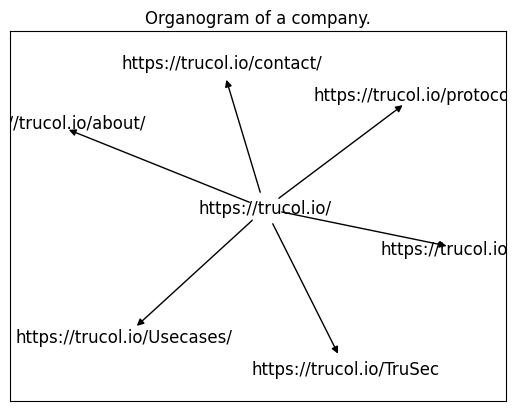

file_path=frontend/https:__trucol.io_.md
file_path=frontend/https:__trucol.io_protocol_.md
file_path=frontend/https:__trucol.io_Usecases_.md
file_path=frontend/https:__trucol.io_faq_.md
file_path=frontend/https:__trucol.io_TruSec.md
file_path=frontend/https:__trucol.io_about_.md
file_path=frontend/https:__trucol.io_contact_.md


In [4]:
"""Add the weaviate summary into the website graph."""
inject_summarisation_into_website_graph(
    data=summarised_data,
    website_graph=website_graph,
    max_nr_of_queries=max_nr_of_queries,
)


visualize_tree_v1(G=website_graph)

create_mdbook(
    graph=website_graph, root=company_urls[0], output_dir=md_book_path
)